In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
import mo_pack
from matplotlib import ticker, cm
import iris.analysis.cartography
import aeolus
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube

In [2]:
warnings.filterwarnings("ignore")


# Import the climate and chemistry data

In [3]:
pcb_b = iris.load('../data_b/pcb_bnox_musc_7440_120_2.nc')

In [4]:
lfr = pcb_b.extract_cube('Stash code = 21115')
avtlfr = lfr.collapsed('t', iris.analysis.MEAN)

convect_d = pcb_b.extract_cube('DEEP CONVECTION INDICATOR')
convect_m = pcb_b.extract_cube('MID LEVEL CONVECTION INDICATOR')    
convect_s = pcb_b.extract_cube('SHALLOW CONVECTION INDICATOR')

# Some standard cube operations

In [13]:
from iris.util import broadcast_to_shape, guess_coord_axis, is_regular
from iris.analysis.cartography import wrap_lons

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume

def _is_longitude_global(lon_points):
    """Return True if array of longitudes covers the whole sphere."""
    dx = np.diff(lon_points)[0]  # assume regular grid
    case_0_360 = ((lon_points[0] - dx) <= 0) and ((lon_points[-1] + dx) >= 360)
    case_pm180 = ((lon_points[0] - dx) <= -180) and ((lon_points[-1] + dx) >= 180)
    return case_0_360 or case_pm180

def roll_cube_pm180(cube_in):
    """
    Take a cube spanning 0...360 degrees in longitude and roll it to -180...180 degrees.

    Works with global model output, and in some cases for regional.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude and latitude coordinates.
    model: aeolus.model.Model, optional
        Model class with a relevant longitude coordinate name.

    Returns
    -------
    iris.cube.Cube

    See also
    --------
    aeolus.coord.roll_cube_0_360
    """
    cube = cube_in.copy()
    #coord_name = model.x  # get the name of the longitude coordinate
    xcoord = cube.coord('longitude')
    if (xcoord.points >= 0.0).all():
        assert is_regular(xcoord), "Operation is only valid for a regularly spaced coordinate."
        if _is_longitude_global(xcoord.points):
            # Shift data symmetrically only when dealing with global cubes
            cube.data = np.roll(cube.data, len(xcoord.points) // 2, axis=-1)

        if xcoord.has_bounds():
            bounds = wrap_lons(xcoord.bounds, -180, 360)  # + subtract
            bounds = bounds[bounds[:, 0].argsort(axis=0)]
        else:
            bounds = None
        cube.replace_coord(
            xcoord.copy(points=np.sort(wrap_lons(xcoord.points, -180, 360)), bounds=bounds)
        )
    else:
        # Nothing to do, the cube is already centered on 0 longitude
        # unless there is something wrong with longitude
        msg = f"Incorrect {coord_name} values: from {xcoord.points.min()} to {xcoord.points.max()}"
        assert ((xcoord.points >= -180.0) & (xcoord.points <= 180.0)).all(), msg
    return cube

def cuberoll_merid(cube_in):
    roll = roll_cube_pm180(cube_in)
    roll_merid=meridional_mean(roll)
    return roll_merid

def integrate(cube, coord):
    """
    Integrate the cube along a 1D coordinate using the trapezoidal rule.

    Note: `coord` must be one of the dimensional coordinates of the cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Input cube containing the given coordinate.
    coord: str or iris.coords.Coord
        Coordinate for integration.

    Returns
    -------
    iris.cube.Cube
        Integrated cube.
    """
    # TODO: allow non-dim coordinates
    c = cube.coord(coord)
    others = [dc.name() for dc in cube.dim_coords if cube.coord_dims(dc) != cube.coord_dims(c)]
    dim = cube.coord_dims(c)[0]
    data = np.trapz(cube.data, c.points, axis=dim)
    res = next(cube.slices(others)).copy(data=data)
    res.units = cube.units * c.units
    res.remove_coord(c)
    res.rename(f"integral_of_{cube.name()}_wrt_{c.name()}")
    # ensure_bounds(cube, [c])
    # delta = iris.coords.AuxCoord(c.bounds[:, 1] - c.bounds[:, 0], units=c.units)
    # res = multiply(cube, delta, dim=dim).collapsed(c, iris.analysis.SUM)
    return res


In [22]:
tsurf = pcb_b.extract_cube('surface_temperature')
avttsurf = tsurf.collapsed('t', iris.analysis.MEAN)
tair = pcb_b.extract_cube('air_temperature')
avttair = tair.collapsed('t', iris.analysis.MEAN)
pair = pcb_b.extract_cube('air_pressure')
avtpair = pair.collapsed('t', iris.analysis.MEAN)
uwind = pcb_b.extract_cube('eastward_wind')
avtuwind = uwind.collapsed('t', iris.analysis.MEAN)
vwind = pcb_b.extract_cube('northward_wind')
avtvwind = vwind.collapsed('t', iris.analysis.MEAN)
zwind = pcb_b.extract_cube('upward_air_velocity')
avtzwind = zwind.collapsed('t', iris.analysis.MEAN)

o3column = pcb_b.extract_cube('Stash code = 50219')
avto3column = o3column.collapsed('t', iris.analysis.MEAN)

o3mmr = pcb_b.extract_cube('O3 MASS MIXING RATIO')
avto3mmr = o3mmr.collapsed('t', iris.analysis.MEAN)*29.3/48
ohmmr = pcb_b.extract_cube('OH MASS MIXING RATIO')
avtohmmr = ohmmr.collapsed('t', iris.analysis.MEAN)*29.3/17.008
#NOx/NOy
nommr = pcb_b.extract_cube('NO MASS MIXING RATIO')
avtnommr = nommr.collapsed('t', iris.analysis.MEAN)*29.3/30.01
no2mmr= pcb_b.extract_cube('Stash code = 34996')
avtno2mmr= no2mmr.collapsed('t', iris.analysis.MEAN)*29.3/46.0055
no3mmr = pcb_b.extract_cube('NO3 MASS MIXING RATIO')
avtno3mmr= no3mmr.collapsed('t', iris.analysis.MEAN)*29.3/62.0049
hno3mmr = pcb_b.extract_cube('HONO2 MASS MIXING RATIO')
avthno3mmr= hno3mmr.collapsed('t', iris.analysis.MEAN)*29.3/63.0128
nmmr = pcb_b.extract_cube('N MASS MIXING RATIO')
avtnmmr= nmmr.collapsed('t', iris.analysis.MEAN)*29.3/14.0067
n2o5mmr = pcb_b.extract_cube('N2O5 MASS MIXING RATIO')
avtn2o5mmr= n2o5mmr.collapsed('t', iris.analysis.MEAN)*29.3/108.01
ho2no2mmr = pcb_b.extract_cube('HO2NO2 MASS MIXING RATIO')
avtho2no2mmr= ho2no2mmr.collapsed('t', iris.analysis.MEAN)*29.3/79.0122
n2ommr = pcb_b.extract_cube('N2O MASS MIXING RATIO')
avtn2ommr = n2ommr.collapsed('t', iris.analysis.MEAN)*29.3/44.013
honommr = pcb_b.extract_cube('HONO MASS MIXING RATIO')
avthonommr = honommr.collapsed('t', iris.analysis.MEAN)*29.3/47.01344

In [23]:
volume = volume_weights_cube2(avto3mmr)
area = area_weights_cube(avto3mmr, r_planet=None, normalize=False, model=aeolus.model.um)

# Calculate wind speed vector

In [26]:
rotuwind = avtuwind.regrid(avtvwind, iris.analysis.Linear())
ulon = rotuwind.coord('longitude')
vlon = avtvwind.coord('longitude')
print(vlon.var_name)
#The longitude points go from 180 to 540, so subtract 360 from them
ulon.points = ulon.points #- 180.0
vlon.points = vlon.points #- 180.0

    # Create a cube containing the wind speed
windspeed = (rotuwind** 2 + avtvwind ** 2) ** 0.5
windspeed.rename('windspeed')
#rotuwind[0, :, :].data
#vwind[0, :, :].data

xe = ulon.points
ye = rotuwind.coord('latitude').points
ue = rotuwind[18, :, :].data
ve = avtvwind[18, :, :].data



longitude


# Calculation of vertical columns

In [27]:
import cftime


nsurf=(avtpair[0,:,:])/((1.38*10**(-23))*avttsurf) #nair in molec/m3
nair=(avtpair[1:,:,:]*volume[:,:,:])/((1.38*10**(-23))*avttair[:,:,:]) #nair in molec/gridbox

In [28]:
o3vcol = avto3mmr*nair/volume #n_o3 in molec/m3
novcol = avtnommr*nair/volume 
no2vcol = avtno2mmr*nair/volume 
hno3vcol = avthno3mmr*nair/volume
no3vcol = avtno3mmr*nair/volume 
n2o5vcol = avtn2o5mmr*nair/volume 
honovcol = avthonommr*nair/volume
ho2no2vcol = avtho2no2mmr*nair/volume
ohvcol = avtohmmr*nair/volume #n_o3 in molec/m3


In [29]:
o3vcol=integrate(o3vcol, 'Hybrid height')
novcol=integrate(novcol, 'Hybrid height')
no2vcol=integrate(no2vcol, 'Hybrid height')
no3vcol=integrate(no3vcol, 'Hybrid height')
hno3vcol=integrate(hno3vcol, 'Hybrid height')
n2o5vcol=integrate(n2o5vcol, 'Hybrid height')
honovcol=integrate(honovcol, 'Hybrid height')
ho2no2vcol=integrate(ho2no2vcol, 'Hybrid height')


In [30]:
avtnommr_roll_merid = cuberoll_merid(avtnommr)
avtno2mmr_roll_merid = cuberoll_merid(avtno2mmr)
avthno3mmr_roll_merid = cuberoll_merid(avthno3mmr)
avtno3mmr_roll_merid = cuberoll_merid(avtno3mmr)
avtn2o5mmr_roll_merid = cuberoll_merid(avtn2o5mmr)
avto3mmr_roll_merid = cuberoll_merid(avto3mmr)


# O$_3$ spatial distribution as shown in Figure 5 of Braam et al. (2022)

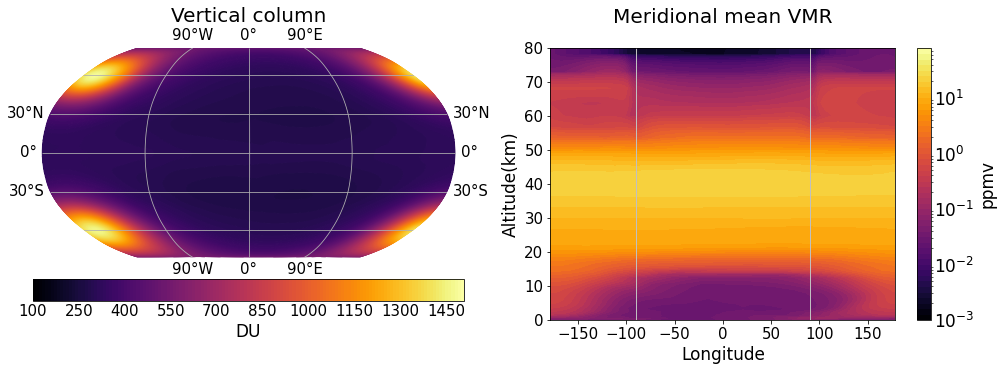

In [31]:
lons = avto3mmr.coord("longitude").points
lats = avto3mmr.coord("latitude").points

levscol=np.arange(100,1520,10)
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(121,  projection=ccrs.Robinson(central_longitude=0))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(avto3column[0,:,:], levels=levscol, cmap='inferno')
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)
cbar.ax.set_xlabel('DU', fontsize=17)
cbar.ax.tick_params(length=0, labelsize=15)
plt.gca().set_title('Vertical column', fontsize=20)
    # Add coastlines to the map created by contourf.
    #plt.gca().coastlines()
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.rotate_labels = False

lev_exp = np.arange(-3,2,0.1)
levs = np.power(10, lev_exp)
#levs = np.arange(0,0.15,0.0075)
ax = fig.add_subplot(122, facecolor='black')
plt.ylim(0,80)
cs = plt.contourf(avto3mmr_roll_merid[:, :].coord("longitude").points, avto3mmr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avto3mmr_roll_merid[:, :].data*10**6, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('ppmv', rotation=90, fontsize=17)
cbar.ax.tick_params(length=0, labelsize=17)
plt.gca().set_title(r'Meridional mean VMR', fontsize=20, pad=25)
plt.xlabel('Longitude', fontsize=17)
plt.ylabel('Altitude(km)', fontsize=17)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')
plt.show()

# NO$_y$ distribution as shown in Figure 10 of Braam et al. (2022)

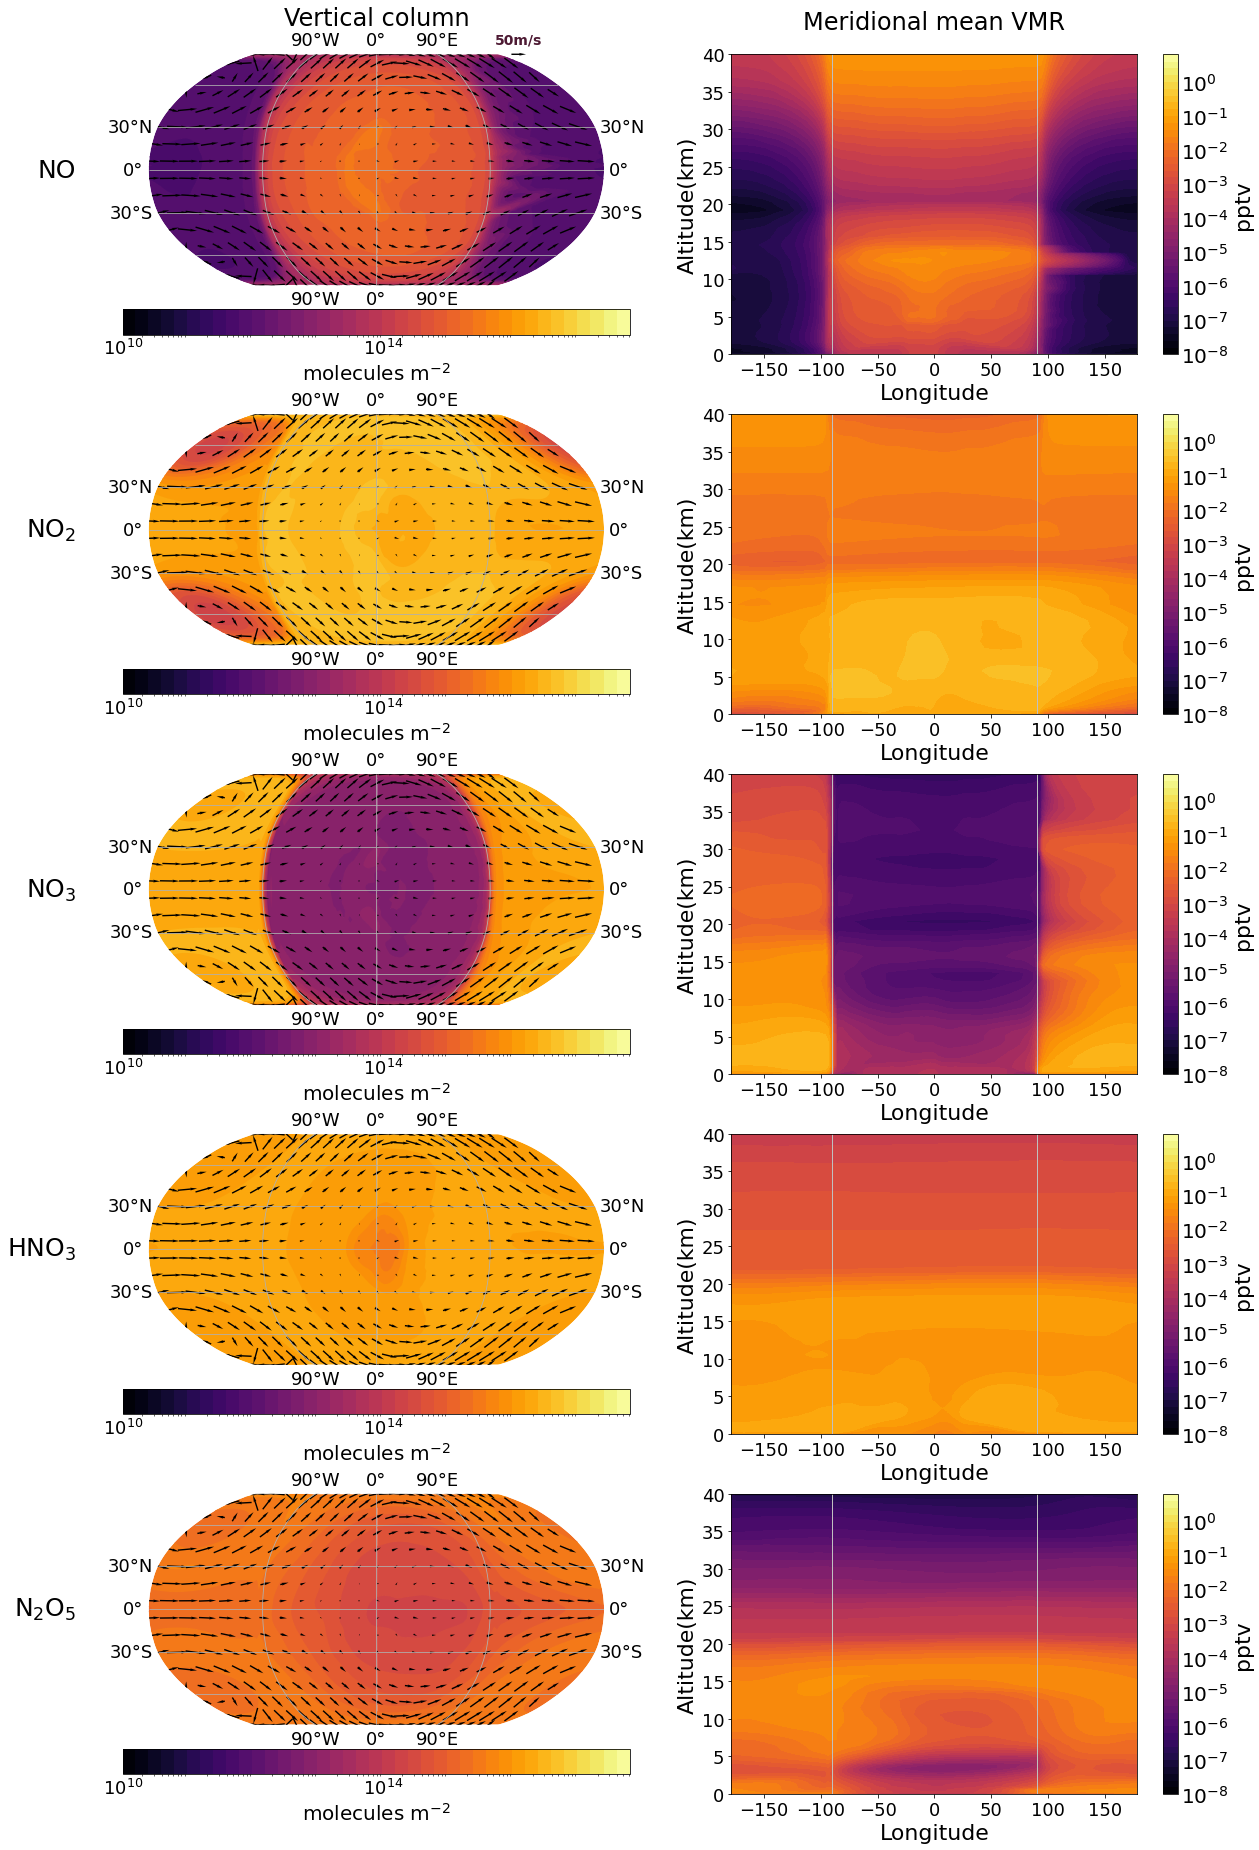

In [32]:
lons = avtnommr.coord("longitude").points
lats = avtnommr.coord("latitude").points
lev_expcol = np.arange(10,18,0.2)
levscol = np.power(10, lev_expcol)
fig = plt.figure(figsize=(20,32))

ax = fig.add_subplot(521,  projection=ccrs.Robinson(central_longitude=0))
ax.annotate('NO', xy=(-300, 0.5), xytext=(-300, 0),
                textcoords='offset points',
                size=25, ha='right', va='center')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(novcol[:,:], levels=levscol, locator=ticker.LogLocator(), cmap='inferno')
qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
ax.quiverkey(qv1, 0.4, 0.88, 50, r'50m/s', labelcolor=(0.3, 0.1, .2, 1),
                      labelpos='N', coordinates = 'figure', fontproperties={'size': 14, 'weight': 'bold'})
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)
cbar.ax.set_xlabel('molecules m$^{-2}$', fontsize=20, va='top')
cbar.ax.tick_params(length=0, labelsize=18)
plt.gca().set_title('Vertical column', fontsize=24)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.rotate_labels = False

lev_exp = np.arange(-8,1,0.2)
levs = np.power(10, lev_exp)
ax = fig.add_subplot(522, facecolor='black')
plt.ylim(0,40)
cs = plt.contourf(avtnommr_roll_merid[:, :].coord("longitude").points, avtnommr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avtnommr_roll_merid[:, :].data*10**12, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('pptv', rotation=90, fontsize=22)
cbar.ax.tick_params(length=0, labelsize=20)
plt.gca().set_title(r'Meridional mean VMR', fontsize=24, pad=25)
plt.xlabel('Longitude', fontsize=22)
plt.ylabel('Altitude(km)', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')


ax = fig.add_subplot(523,  projection=ccrs.Robinson(central_longitude=0))
ax.annotate('NO$_{2}$', xy=(-300, 0.5), xytext=(-300, 0),
                textcoords='offset points',
                size=25, ha='right', va='center')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(no2vcol[:,:], levels=levscol, locator=ticker.LogLocator(), cmap='inferno')
qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)#,cax = cbaxes)
cbar.ax.set_xlabel('molecules m$^{-2}$', fontsize=20, va='top')
cbar.ax.tick_params(length=0, labelsize=18)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.rotate_labels = False

ax = fig.add_subplot(524, facecolor='black')
plt.ylim(0,40)
cs = plt.contourf(avtno2mmr_roll_merid[:, :].coord("longitude").points, avtno2mmr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avtno2mmr_roll_merid[:, :].data*10**12, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('pptv', rotation=90, fontsize=22)
cbar.ax.tick_params(length=0, labelsize=20)
plt.xlabel('Longitude', fontsize=22)
plt.ylabel('Altitude(km)', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')

ax = fig.add_subplot(525,  projection=ccrs.Robinson(central_longitude=0))
ax.annotate('NO$_{3}$', xy=(-300, 0.5), xytext=(-300, 0),
                textcoords='offset points',
                size=25, ha='right', va='center')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(no3vcol[:,:], levels=levscol, locator=ticker.LogLocator(), cmap='inferno')
qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)#,cax = cbaxes)
cbar.ax.set_xlabel('molecules m$^{-2}$', fontsize=20, va='top')
cbar.ax.tick_params(length=0, labelsize=18)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.rotate_labels = False

ax = fig.add_subplot(526, facecolor='black')
plt.ylim(0,40)
cs = plt.contourf(avtno3mmr_roll_merid[:, :].coord("longitude").points, avtno3mmr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avtno3mmr_roll_merid[:, :].data*10**12, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('pptv', rotation=90, fontsize=22)
cbar.ax.tick_params(length=0, labelsize=20)
plt.xlabel('Longitude', fontsize=22)
plt.ylabel('Altitude(km)', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')

levscol = np.power(10, lev_expcol)
ax = fig.add_subplot(527,  projection=ccrs.Robinson(central_longitude=0))
ax.annotate('HNO$_{3}$', xy=(-300, 0.5), xytext=(-300, 0),
                textcoords='offset points',
                size=25, ha='right', va='center')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(hno3vcol[:,:], levels=levscol, locator=ticker.LogLocator(), cmap='inferno')
qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)#,cax = cbaxes)
cbar.ax.set_xlabel('molecules m$^{-2}$', fontsize=20, va='top')
cbar.ax.tick_params(length=0, labelsize=18)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.rotate_labels = False


ax = fig.add_subplot(528, facecolor='black')
plt.ylim(0,40)
cs = plt.contourf(avthno3mmr_roll_merid[:, :].coord("longitude").points, avthno3mmr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avthno3mmr_roll_merid[:, :].data*10**12, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('pptv', rotation=90, fontsize=22)
cbar.ax.tick_params(length=0, labelsize=20)
plt.xlabel('Longitude', fontsize=22)
plt.ylabel('Altitude(km)', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')


levscol = np.power(10, lev_expcol)
ax = fig.add_subplot(529,  projection=ccrs.Robinson(central_longitude=0))
ax.annotate('N$_{2}$O$_{5}$', xy=(-300, 0.5), xytext=(-300, 0),
                textcoords='offset points',
                size=25, ha='right', va='center')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
cs = iplt.contourf(n2o5vcol[:,:], levels=levscol, locator=ticker.LogLocator(), cmap='inferno')
qv1=ax.quiver(xe[::6], ye[::6], ue[::6, ::6], ve[::6, ::6], pivot='middle', headwidth=2, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, orientation='horizontal', pad=0.08)#,cax = cbaxes)
cbar.ax.set_xlabel('molecules m$^{-2}$', fontsize=20, va='top')
cbar.ax.tick_params(length=0, labelsize=18)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.xlocator = ticker.FixedLocator([-90, 0, 90])
gl.ylocator = ticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.rotate_labels = False


ax = fig.add_subplot(5,2,10, facecolor='black')
plt.ylim(0,40)
cs = plt.contourf(avtn2o5mmr_roll_merid[:, :].coord("longitude").points, avtn2o5mmr_roll_merid[:, :].coord("Hybrid height").points/1000,
                   avtn2o5mmr_roll_merid[:, :].data*10**12, levels=levs, locator=ticker.LogLocator(), cmap='inferno')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('pptv', rotation=90, fontsize=22)
cbar.ax.tick_params(length=0, labelsize=20)
plt.xlabel('Longitude', fontsize=22)
plt.ylabel('Altitude(km)', fontsize=22)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.axvline(-90, color='silver', ls='-', lw='1')
plt.axvline(90, color='silver', ls='-', lw='1')
plt.show()

